# ResNet Test
I will build cnn with and without residual shortcut, then compare their performance. This is NOT a thorough test.

I will use MNIST dataset for this simple test 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data', validation_size=0, one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


Define method to build cnn model 

In [3]:
def define_inputs():
    x = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1])
    y_ = tf.placeholder(dtype=tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(dtype=tf.float32, shape=())
    return x, y_, keep_prob

In [4]:
def cnn_block(layer_in, n_filters, kernel_size, padding="same", is_residual=False, is_batch_norm=False):
    """
    build a block with 2 cnn layers. Relu is used for activation function 
    """
    # first layer
    layer = tf.layers.conv2d(
        inputs=layer_in, 
        filters=n_filters, 
        kernel_size=kernel_size, 
        padding=padding, 
        activation=None)
    if is_batch_norm:
        layer = tf.layers.batch_normalization(layer)
    layer = tf.nn.relu(layer)
    
    # second layer 
    layer = tf.layers.conv2d(
        inputs=layer, 
        filters=n_filters, 
        kernel_size=kernel_size, 
        padding=padding, 
        activation=None)
    if is_batch_norm:
        layer = tf.layers.batch_normalization(layer)
    if is_residual:
        layer += layer_in
    layer = tf.nn.relu(layer)
    
    return layer 

In [5]:
def define_model(x, n_filters, n_blocks, keep_prob, is_residual, is_batch_norm):
    # 28 x 28 x 1 input 
    # for simplicity, the first layer is always the same
    layer_cur = tf.layers.conv2d(x, filters=n_filters, kernel_size=3, padding="same", activation=tf.nn.relu)
    layer_cur = tf.layers.max_pooling2d(layer_cur, pool_size=2, strides=2)
    
    # build multiple blocks 
    for _ in range(n_blocks):
        layer_cur = cnn_block(
            layer_in=layer_cur, 
            n_filters=n_filters, 
            kernel_size=3, 
            is_residual=is_residual, 
            is_batch_norm=is_batch_norm)
    

    # last pooling
    layer_pooling = tf.layers.max_pooling2d(layer_cur, pool_size=2, strides=2)
    # now, 7 x 7 x 8
    
    # for simplicity, the last layer is always the same 
    layer_flatten = tf.reshape(layer_pooling, shape=[-1, 7*7*n_filters])
    layer_last = tf.layers.dense(layer_flatten, units=1024, activation=tf.nn.relu)
    layer_last = tf.nn.dropout(layer_last, keep_prob=keep_prob)
    logit = tf.layers.dense(layer_last, units=10, activation=None)
    
    return logit
        

In [20]:
def train_model(n_blocks, n_steps, is_residual, is_batch_norm=True):
    tf.reset_default_graph()
    x, y_, keep_prob = define_inputs()
    logit = define_model(x, n_filters=256, n_blocks=n_blocks, keep_prob=keep_prob, 
                         is_residual=is_residual, is_batch_norm=is_batch_norm)

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logit))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(logit,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    train_acc = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for i in range(n_steps):
            batch = mnist.train.next_batch(50)
            imgs = batch[0].reshape(-1, 28, 28, 1)
            labels = batch[1]
            if i%100 == 0:
                train_accuracy = accuracy.eval(feed_dict={x:imgs, y_: labels, keep_prob: 1})
                train_acc.append(train_accuracy)
                print("step %d, training accuracy %g"%(i, train_accuracy))
            train_step.run(feed_dict={x: imgs, y_: batch[1], keep_prob: 0.5})
        
        test_acc = 0
        for j in range(100):
            batch_test = mnist.test.next_batch(100)
            imgs_test = batch[0].reshape(-1, 28, 28, 1)
            labels_test = batch[1]
            test_acc += accuracy.eval(
                feed_dict={x: imgs_test, y_: labels_test, keep_prob: 1})
        test_acc = test_acc/100
        print("test accuracy: {0:.4}".format(test_acc))
    
    return train_acc, test_acc 

Testing plain CNN with 16 blocks (32 layers) + 1 cnn + 2 dense layers; thus total 35 layers 

In [23]:
plain_train_acc, plain_test_acc = train_model(n_blocks=16, n_steps=20000, is_residual=False)

step 0, training accuracy 0.08
step 100, training accuracy 0.1
step 200, training accuracy 0.1
step 300, training accuracy 0.08
step 400, training accuracy 0.06
step 500, training accuracy 0.22
step 600, training accuracy 0.12
step 700, training accuracy 0.08
step 800, training accuracy 0.08
step 900, training accuracy 0.18
step 1000, training accuracy 0.04
step 1100, training accuracy 0.14
step 1200, training accuracy 0.08
step 1300, training accuracy 0.06
step 1400, training accuracy 0.06
step 1500, training accuracy 0.08
step 1600, training accuracy 0.06
step 1700, training accuracy 0.08
step 1800, training accuracy 0.08
step 1900, training accuracy 0.1
step 2000, training accuracy 0.12
step 2100, training accuracy 0.06
step 2200, training accuracy 0.12
step 2300, training accuracy 0.06
step 2400, training accuracy 0.04
step 2500, training accuracy 0.12
step 2600, training accuracy 0.1
step 2700, training accuracy 0.08
step 2800, training accuracy 0.18
step 2900, training accuracy 0

Test Residual Network with 16 blocks (32 layers) + 1 cnn + 2 dense layers; thus total 35 layers 

In [24]:
res_train_acc, res_test_acc = train_model(n_blocks=16, n_steps=20000, is_residual=True)

step 0, training accuracy 0.04
step 100, training accuracy 0.94
step 200, training accuracy 0.98
step 300, training accuracy 0.98
step 400, training accuracy 0.98
step 500, training accuracy 1
step 600, training accuracy 1
step 700, training accuracy 0.96
step 800, training accuracy 0.98
step 900, training accuracy 1
step 1000, training accuracy 1
step 1100, training accuracy 1
step 1200, training accuracy 1
step 1300, training accuracy 1
step 1400, training accuracy 1
step 1500, training accuracy 1
step 1600, training accuracy 1
step 1700, training accuracy 1
step 1800, training accuracy 1
step 1900, training accuracy 1
step 2000, training accuracy 1
step 2100, training accuracy 1
step 2200, training accuracy 1
step 2300, training accuracy 0.98
step 2400, training accuracy 1
step 2500, training accuracy 1
step 2600, training accuracy 0.98
step 2700, training accuracy 1
step 2800, training accuracy 1
step 2900, training accuracy 1
step 3000, training accuracy 1
step 3100, training accu

Plot the training accuracy of both networks 

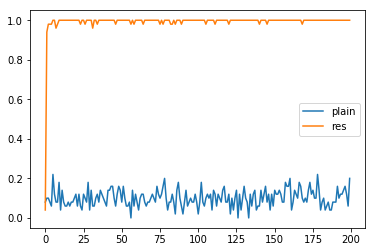

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(plain_train_acc, label="plain")
ax.plot(res_train_acc, label="res")
ax.legend()
plt.show()